<a href="https://colab.research.google.com/github/Jepees/NLP-with-Disaster-Tweets/blob/main/Kaggle_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import string
import torch
import nltk
import re
import os

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from scipy.sparse import hstack
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

np.random.seed(12)
plt.style.use('default')    # Reset style matplotlib
plt.rcdefaults()            # Reset rcParams ke default
sns.reset_defaults()        # Reset style seaborn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [111]:
try:
    df_train = pd.read_csv("https://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/train.csv")
    df_test = pd.read_csv("https://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/test.csv")
except:
    df_train = pd.read_csv("https://drive.google.com/uc?id=1ihd1SGi31mKs6u-UhTSh4oV4HwukGzkU")
    df_test = pd.read_csv("https://drive.google.com/uc?id=1EmAmpoohDoUzN_vTj68XGL1e2GyHWm5N")


print(f"total data train: {df_train.shape[0]}\ntotal data test : {df_test.shape[0]}")


total data train: 7613
total data test : 3263


## Exploratory Data

In [112]:
df_train.sample(5)

,id,keyword,location,text,target
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
7418,10611,wounded,Americas Newsroom,Police officer wounded suspect dead after exch...,1
6142,8761,siren,Hame,There's a weird siren going off here...I hope ...,1
3927,5584,flood,NaN,85V-265V 10W LED Warm White Light Motion Senso...,0
7215,10334,weapon,Not Of This World,Iranian warship points weapon at American heli...,1


In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [114]:
df_train['target'].value_counts()

,count
target,
0,4342
1,3271


In [115]:
df_train.duplicated().sum()

np.int64(0)

In [116]:
df_train.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [117]:
# df_train['text'] = df_train[['keyword', 'location', 'text']].agg(lambda x: ' '.join(x.dropna()), axis=1)
# df_test['text'] = df_test[['keyword', 'location', 'text']].agg(lambda x: ' '.join(x.dropna()), axis=1)

In [118]:
df_train = df_train.drop(['location','keyword'],axis=1)
df_test = df_test.drop(['location','keyword'],axis=1)

df_train.sample(6)

,id,text,target
1724,2487,Monkey just collided heads with our Ninja. Com...,0
3232,4639,beyond stressed beyond hysteria into the grey ...,0
503,728,@eunice_njoki aiii she needs to chill and answ...,0
5728,8175,Rescuers are searching for hundreds of migrant...,1
1610,2325,Ashes 2015: Australia totally collapse and the...,0
2326,3342,Demolished My Personal Best http://t.co/ImULL...,0


In [119]:
df_train[df_train['target'] == 0]['target'].value_counts().iloc[0]

np.int64(4342)

In [120]:
print(f"total tweet tentang bencana      : {df_train['target'].value_counts().iloc[1]} | {round(100*((df_train['target'].value_counts().iloc[1]) / (df_train.shape[0])), 2)}%")
print(f"total tweet bukan tentang bencana: {df_train['target'].value_counts().iloc[0]} | {round(100*((df_train['target'].value_counts().iloc[0]) / (df_train.shape[0])), 2)}%")


total tweet tentang bencana      : 3271 | 42.97%
total tweet bukan tentang bencana: 4342 | 57.03%


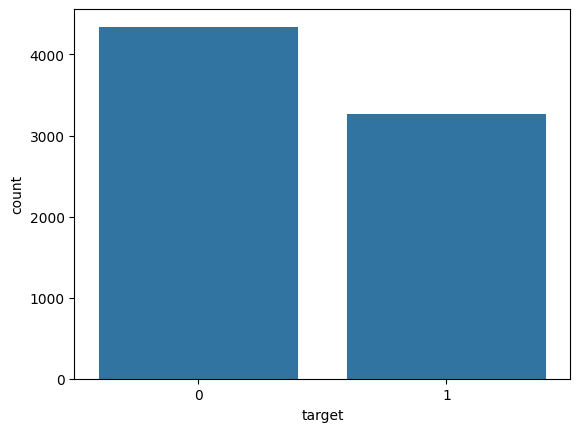

In [121]:
sns.countplot(x='target', data=df_train)
plt.show()

In [122]:
print("contoh tweet bukan tentang bencana:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['text'].values[i]}")

print("\ncontoh tweet tentang bencana:")
for i in range(5):
    print(f"{i}. {df_train[df_train['target'] == 1].sample(10)['text'].values[i]}")

contoh tweet bukan tentang bencana:
1. Reddit updates content policy promises to quarantine Û÷extremely offensiveÛª communities http://t.co/PLmIWOfpom
2. Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
3. Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm
4. Reddit Will Now Quarantine Offensive Content: Reddit co-founder and CEO Steve Huffman has unveiled more specif... http://t.co/LJMGdpDLvs
5. Trouble with mental fog? Consider these tests: http://t.co/XAerMBMvlv

contoh tweet tentang bencana:
0. Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!
1. #Glimpses: Hyderabad deluged by heavy rainfall | http://t.co/DctV1uJLHc http://t.co/QOx1jNQSAU
2. Truth...
https://t.co/2Y4RGob7pj
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/mVes6VsSyN
3. Officials rescue 367 migrants off Libya; 25 bod

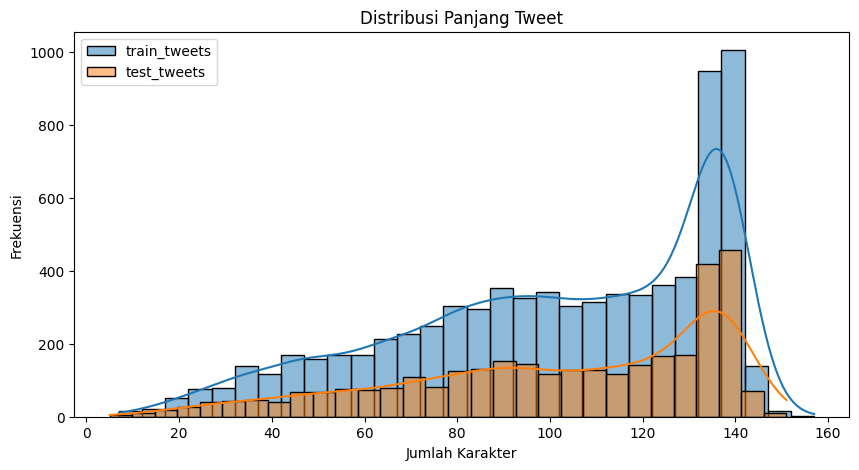

In [123]:
# Plot distribusi panjang tweet
plt.figure(figsize=(10, 5))
sns.histplot(df_train['text'].apply(len), bins=30, kde=True, label="train_tweets")
sns.histplot(df_test['text'].apply(len), bins=30, kde=True, label="test_tweets")
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

In [124]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

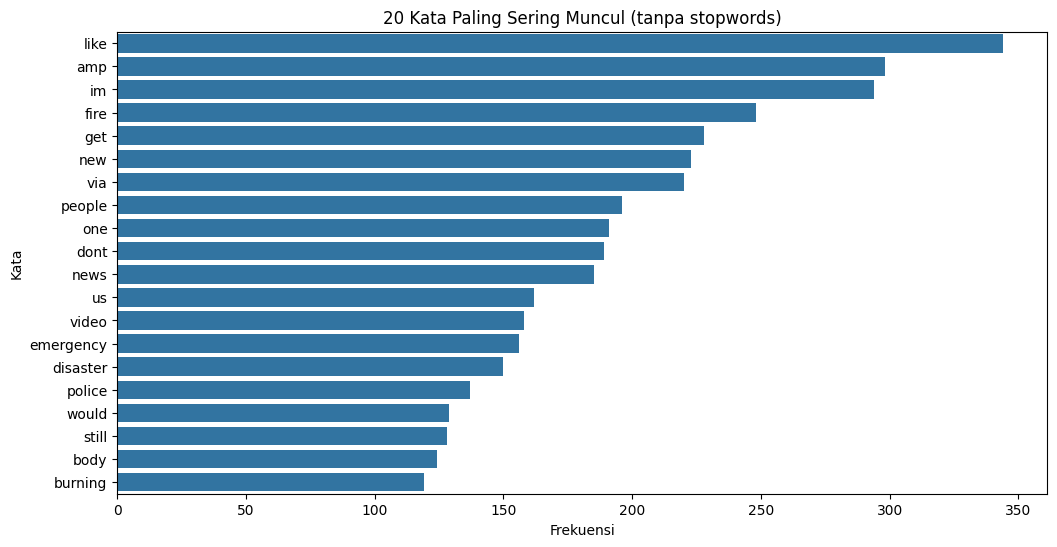

In [125]:
stop_words = set(stopwords.words('english'))
all_words = []

for text in df_train['text']:
    words = clean_text(text).split()
    words = [word for word in words if word not in stop_words]
    all_words.extend(words)

# Ambil 20 kata paling sering
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(freqs), y=list(words))
plt.title('20 Kata Paling Sering Muncul (tanpa stopwords)')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

## Data Preprocessing

In [126]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and train datasets
df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['text'].apply(lambda x: clean_text(x))

# updated text
print("contoh tweet bukan tentang bencana yang sudah dibersihkan:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['clean_text'].values[i]}")


contoh tweet bukan tentang bencana yang sudah dibersihkan:
1.  got it last month when i went into the ee shop glad it hasnt blown up yet 
2. sitting in a cafe enjoying a bite and cramming for my meeting during my whirlwind  in nyc 
3. so the ahamedis think the messiah had already come  years ago where is armageddon where is the dajaal where is gog amp magog
4. the meaning i picked the one that changed my life overcome fear behold wondertcc catch the light endless 
5. dakota skye gets horny with some porn then gets her juicy pussy pounded  view and download video


In [127]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenator(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words] # Stopword removal + lemmatizing
    # tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]  # Stopword removal + stemming
    tokens = " ".join(tokens)
    return tokens


df_train['tokenize_text'] = df_train['clean_text'].apply(tokenator)
df_test['tokenize_text'] = df_test['clean_text'].apply(tokenator)

In [128]:
df_train.sample(10)

,id,text,target,clean_text,tokenize_text
5844,8350,@ChrisDyson16 Just wait until your friends at ...,0,just wait until your friends at mta ruin it s...,wait friend mta ruin sorrybutitstrue
5453,7775,New technology designed to help prevent danger...,0,new technology designed to help prevent danger...,new technology designed help prevent dangerous...
3573,5105,@CNN the End of Times are upon us. Famine War ...,0,cnn the end of times are upon us famine war de...,cnn end time upon u famine war death plague pr...
7213,10332,Lol\nLook how tough some people talk that live...,1,lollook how tough some people talk that live i...,lollook tough people talk live gang infested c...
4956,7063,THE GLOBAL ECONOMIC MELTDOWN is out! http://t....,1,the global economic meltdown is out stories v...,global economic meltdown story via aleisstokes...
5273,7535,Refugio oil spill may have been costlier bigge...,1,refugio oil spill may have been costlier bigge...,refugio oil spill may costlier bigger projected
6402,9149,Islamic State claims suicide bombing at Saudi ...,1,islamic state claims suicide bombing at saudi ...,islamic state claim suicide bombing saudi arab...
4731,6727,i lava you! ????,0,i lava you,lava
187,266,Pakistan air ambulance helicopter crash kills ...,1,pakistan air ambulance helicopter crash kills ...,pakistan air ambulance helicopter crash kill nine
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada


## Text Vectorization

In [129]:
# Inisialisasi vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

# Fit dan transform teks
X_tfidf = tfidf_vectorizer.fit_transform(df_train['tokenize_text'])
X_test = tfidf_vectorizer.transform(df_test['tokenize_text'])

# Label
y = df_train['target']

print(f"Shape TFIDFVectorizer: {X_tfidf.shape}\n")

Shape TFIDFVectorizer: (7613, 10000)



In [130]:
selector = SelectKBest(chi2, k=3000)
X_selected = selector.fit_transform(X_tfidf, y)
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=12, stratify=y)
X_test = selector.transform(X_test)

## Training Models

### Logistik Regression

In [131]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=10000, class_weight='balanced', C=1, penalty="l2", solver='liblinear')

# Gunakan stratified fold agar proporsi label stabil di tiap fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Tentukan metrik yang ingin dicek
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Lakukan cross-validation
cv_results = cross_validate(lr_model, X_train, y_train, cv=cv, scoring=scoring)

# Tampilkan hasil per metrik
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()} : {mean_score:.4f} (+/- {std_score:.4f})")

ACCURACY : 0.8164 (+/- 0.0091)
PRECISION : 0.8092 (+/- 0.0079)
RECALL : 0.7493 (+/- 0.0169)
F1 : 0.7781 (+/- 0.0126)


In [132]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, penalty="l2", solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [133]:
# Prediksi
y_pred_lr = lr_model.predict(X_val)

# print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr))
# print(confusion_matrix(y_val, y_pred_lr))
print("Akurasi:", accuracy_score(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       869
           1       0.82      0.79      0.81       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

Akurasi: 0.8371634931057124


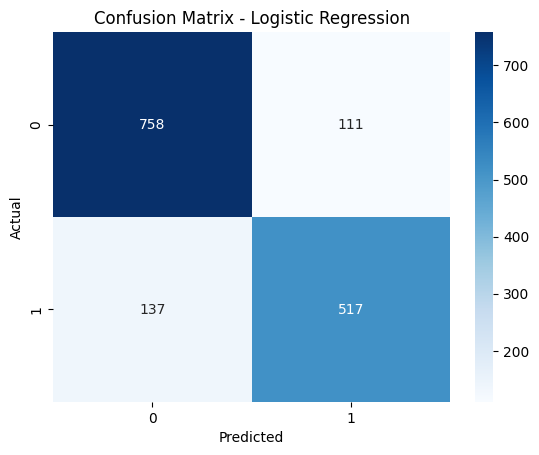

In [134]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_val, y_pred_lr, "Confusion Matrix - Logistic Regression")


### Multinomial Naive-Bayes

In [135]:
# Logistic Regression
best_params = {
    'alpha': 0.01,
    'fit_prior': True,
    'class_prior': [0.5, 0.5]
}

MultiNB_model = MultinomialNB(**best_params)

# Gunakan stratified fold agar proporsi label stabil di tiap fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Tentukan metrik yang ingin dicek
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Lakukan cross-validation
cv_results = cross_validate(MultiNB_model, X_train, y_train, cv=cv, scoring=scoring)

# Tampilkan hasil per metrik
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()} : {mean_score:.4f} (+/- {std_score:.4f})")

ACCURACY : 0.8473 (+/- 0.0073)
PRECISION : 0.8639 (+/- 0.0124)
RECALL : 0.7654 (+/- 0.0100)
F1 : 0.8116 (+/- 0.0088)


In [136]:
# 1. Buat model baru dengan parameter terbaik
best_params = {
    'alpha': 0.01,
    'fit_prior': True,
    'class_prior': [0.5, 0.5]
}

MultiNB_model = MultinomialNB(**best_params)

# 2. Latih model pada data latih
MultiNB_model.fit(X_train, y_train)

# 3. Evaluasi model pada data uji
y_pred_NB = MultiNB_model.predict(X_val)

print("\n=== Final Naive Bayes Model ===")
print(classification_report(y_val, y_pred_NB))
print("Test Accuracy:", accuracy_score(y_val, y_pred_NB))



=== Final Naive Bayes Model ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       869
           1       0.86      0.81      0.83       654

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.86      1523
weighted avg       0.86      0.86      0.86      1523

Test Accuracy: 0.8594878529218647


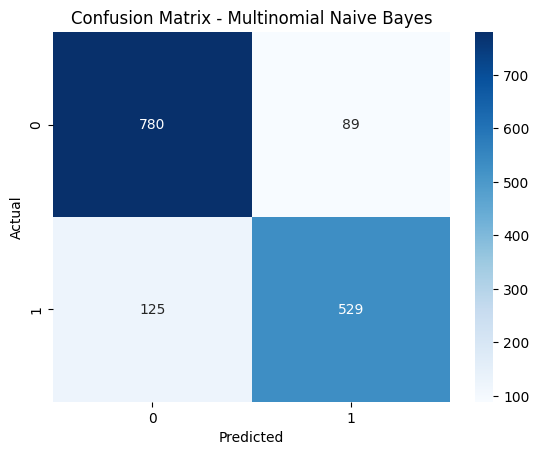

In [137]:
plot_cm(y_val, y_pred_NB, "Confusion Matrix - Multinomial Naive Bayes")

## Predict Test

### Logistic Regression

In [138]:
y_lr = lr_model.predict(X_test)
y_lr

array([1, 1, 1, ..., 1, 1, 1])

In [139]:
sub_lr = df_test.copy()
sub_lr['target'] = y_lr
sub_lr = sub_lr[['id', 'target']]
sub_lr

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [140]:
sub_lr['target'].value_counts()

,count
target,
0,1969
1,1294


In [141]:
sub_lr.to_csv("submission_lr.csv", index=False)

### Multinomial Naive-Bayes

In [142]:
y_NB = MultiNB_model.predict(X_test)
y_NB

array([1, 0, 1, ..., 1, 1, 1])

In [146]:
sub_NB = df_test.copy()
sub_NB['target'] = y_NB
sub_NB = sub_NB[['id', 'target']]
sub_NB

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [147]:
sub_NB['target'].value_counts()

,count
target,
0,2025
1,1238


In [149]:
sub_NB.to_csv("submission_nb.csv", index=False)